# greatpy vs GREAT 

For each file, the function returns a scatterplot allowing the comparison between the binomial and hypergeometric p-value of greatpy vs GREAT, the Pearson coefficient for each of these representations. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great
import pandas as pd
from math import inf
from numpy import log,nan, int64,cov,corrcoef
from scipy.stats import pearsonr
import os 
import re

import warnings
warnings.filterwarnings('ignore')

import time

In [3]:
t = []

for path in os.listdir("../data/tests/test_data/input/"):
    sp = path.split(".")
    id = sp[0][:2]
    name = sp[0][3:]
    great_out = ""
    great_asso = ""

    for out_path in os.listdir("../data/tests/test_data/output/"):
        if out_path.split("_")[0] == id:
            if re.match(".*hg19.*", out_path) != None: assembly = "hg19"
            else: assembly = "hg38"
            if re.match(".*output.*", out_path) != None: great_out = "../data/tests/test_data/output/" + out_path
            else: great_asso = "../data/tests/test_data/output/" + out_path
    if assembly == "hg38" : 
        t.append("../data/tests/test_data/input/" + path)
        regdom = f"../data/human/{assembly}/regulatory_domain.bed"
        size = f"../data/human/{assembly}/chr_size.bed"

results = great.tl.GREAT.enrichment_multiple(
    tests = t, 
    regdom_file=regdom,
    chr_size_file=size,    
    annotation_file="../data/human/ontologies.csv",
    annpath=None, 
    binom=True,
    hypergeom=True
)

In [45]:
import matplotlib.pyplot as plt
def get_all_comparison(results, good_gene_associations: bool = True, disp_scatterplot: bool = True, stats: bool = True):
    pp = {
        "name": [],
        "before_pp_greatpy_size": [],
        "before_pp_great_size": [],
        "final_size": [],
        "%_of_GO_from_great_lost": [],
    }
    asso = {
        "name": [],
        "number_good_gene_asso": [],
        "number_genes_asso_lost": [],
        "number_gene_asso_excess": [],
    }

    stat_df = {"name": [], "pearson_binom": [], "pearson_hypergeom": []}

    for path in results.keys() :
        # sp = path.split(".")
        id = path.split("/")[-1].split("_")[0]
        name = path.split("/")[-1].split("_")[1].split(".")[0]
        i = 0
        great_out = ""
        great_asso = ""

        for out_path in os.listdir("../data/tests/test_data/output/"):
            if out_path.split("_")[0] == id:
                if re.match(".*hg19.*", out_path) != None:
                    assembly = "hg19"
                else:
                    assembly = "hg38"

                if re.match(".*output.*", out_path) != None:
                    great_out = "../data/tests/test_data/output/" + out_path
                else:
                    great_asso = "../data/tests/test_data/output/" + out_path
        
        test = path
        regdom = f"../data/human/{assembly}/regulatory_domain.bed"
        size = f"../data/human/{assembly}/chr_size.bed"

        if great_out == "" or great_asso == "":
            return False

        pp["name"].append(name) 
        enrichment_tot = results[test]
        enrichment_tot = great.tl.GREAT.set_bonferroni(enrichment_tot, 0.05)
        enrichment_tot = great.tl.GREAT.set_fdr(enrichment_tot, 0.05)

        great_webserver = pd.read_csv(
            great_out,
            sep="\t",
            comment="#",
            names=[
                "ontologie",
                "term_name",
                "ID",
                "binom_p_value",
                "binom_bonferroni",
                "binom_fdr",
                "hyper_p_value",
                "hyper_bonferroni",
                "hyper_fdr",
            ],
            index_col=False,
            dtype={
                "term_name": "object",
                "ID": "object",
                "binom_p_value": "float64",
                "binom_bonferroni": "float64",
                "binom_fdr": "float64",
                "hyper_p_value": "float64",
                "hyper_bonferroni": "float64",
                "hyper_fdr": "float64",
            },
        )
        great_webserver.rename(columns={"ID": "id"}, inplace=True)
        del great_webserver["ontologie"]
        del great_webserver["term_name"]

        pp["before_pp_greatpy_size"].append(enrichment_tot.shape[0])
        enrichment_tot = enrichment_tot[enrichment_tot.index.isin(list(great_webserver["id"]))]
        pp["final_size"].append(enrichment_tot.shape[0])

        pp["before_pp_great_size"].append(great_webserver.shape[0])
        pp["%_of_GO_from_great_lost"].append(
            round(((great_webserver.shape[0] - enrichment_tot.shape[0]) / great_webserver.shape[0]) * 100, 2)
        )
        great_webserver = great_webserver[great_webserver["id"].isin(list(enrichment_tot.index))]

        great_webserver = great_webserver.sort_values("id")

        if disp_scatterplot or stats:
            binom_greatpy = []
            hyper_greatpy = []
            binom_great = []
            hyper_great = []
            for i in range(enrichment_tot.shape[0]):
                go_id = list(enrichment_tot.index)[i]
                curr_enrichment = enrichment_tot.iloc[i]
                curr_great_webserver = great_webserver.loc[great_webserver["id"] == go_id]
                binom_greatpy.append(float(curr_enrichment["binom_p_value"]))
                hyper_greatpy.append(float(curr_enrichment["hypergeom_p_value"]))
                binom_great.append(float(curr_great_webserver["binom_p_value"]))
                hyper_great.append(float(curr_great_webserver["hyper_p_value"]))
            binom = pd.DataFrame({"binom_greatpy": binom_greatpy, "binom_great": binom_great})
            hyper = pd.DataFrame({"hyper_greatpy": hyper_greatpy, "hyper_great": hyper_great})

            if disp_scatterplot:
                fig = plt.figure(figsize=(10, 5), dpi=80)
                fig.subplots_adjust(hspace=0.4, wspace=0.4)
                ax = fig.add_subplot(2, 2, 1)
                great.pl.scatterplot(binom, colname_x="binom_greatpy", colname_y="binom_great", title=None, ax=ax)
                ax = fig.add_subplot(2, 2, 2)
                great.pl.scatterplot(hyper, colname_x="hyper_greatpy", colname_y="hyper_great", title=None, ax=ax)
                fig.suptitle(f"results for {name}",fontsize = 20)
                plt.show()

            if stats:
                stat_df["name"].append(name)
                stat_df["pearson_binom"].append(pearsonr(binom_great, binom_greatpy)[0])
                stat_df["pearson_hypergeom"].append(pearsonr(hyper_great, hyper_greatpy)[0])

        if good_gene_associations:
            gene_asso_great = pd.read_csv(
                great_asso,
                sep="\t",
                comment="#",
                names=["ontologies", "gene"],
                index_col=False,
                dtype={"ontologies": "object", "gene": "object"},
                usecols=["gene"],
            )
            gene_asso_greatpy = great.tl.get_association(
                test=pd.read_csv(
                    test,
                    sep="\t",
                    comment="#",
                    usecols=[0, 1, 2],
                    names=["chr", "chr_start", "chr_end"],
                    dtype={"chr": "object", "chr_start": "int64", "chr_end": "int64"},
                ),
                regdom=pd.read_csv(
                    regdom,
                    sep="\t",
                    comment="#",
                    names=["chr", "chr_start", "chr_end", "name", "tss", "strand"],
                    dtype={
                        "chr": "object",
                        "chr_start": "int64",
                        "chr_end": "int64",
                        "name": "object",
                        "tss": "int64",
                        "strand": "object",
                    },
                ),
            )

            in_in = gene_asso_great[gene_asso_great["gene"].isin(gene_asso_greatpy)].shape[0]
            in_out = [i for i in list(gene_asso_great["gene"]) if i not in gene_asso_greatpy]
            out_in = [i for i in gene_asso_greatpy if i not in list(gene_asso_great["gene"])]

            asso["name"].append(name)
            asso["number_good_gene_asso"].append(str(in_in))
            asso["number_genes_asso_lost"].append(str(len(in_out)))
            asso["number_gene_asso_excess"].append(str(len(out_in)))

    if stat_df and good_gene_associations:
        return pd.DataFrame(pp), pd.DataFrame(asso), pd.DataFrame(stat_df)

    elif stat_df:
        return pd.DataFrame(pp), pd.DataFrame(stat_df)

    elif good_gene_associations:
        pd.DataFrame(pp), pd.DataFrame(asso)
    else:
        return pd.DataFrame(pp)

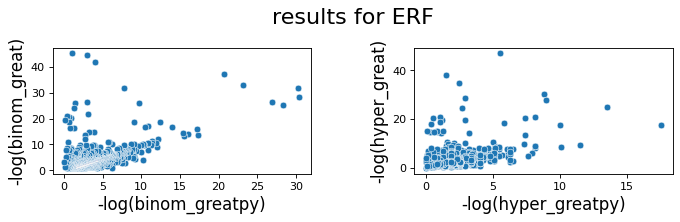

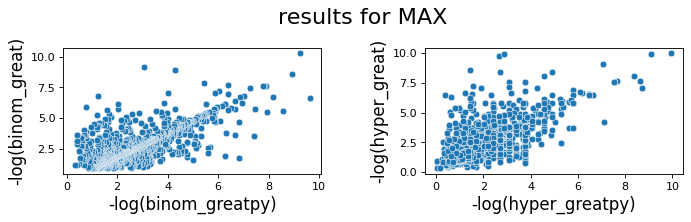

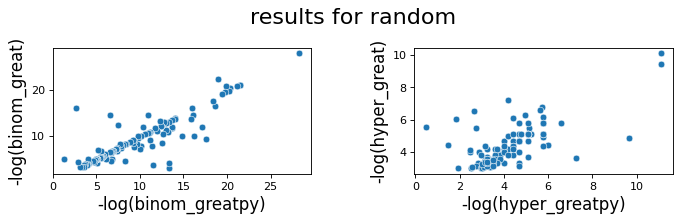

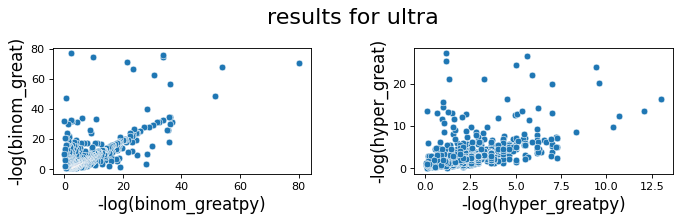

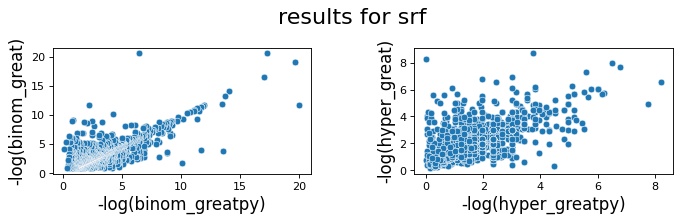

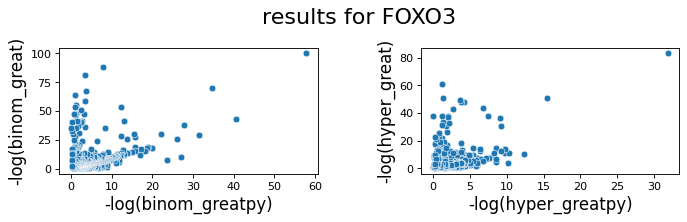

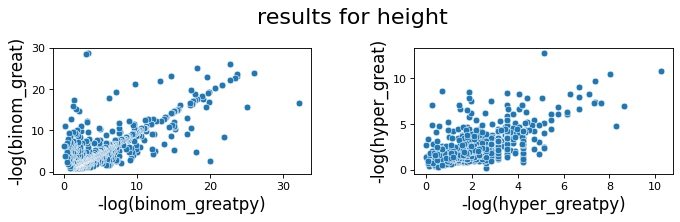

In [46]:
pp,asso,stat = get_all_comparison(results)

## GREAT vs greatpy correlation

In [17]:
pd.options.display.float_format = '{:.2f}'.format

In [47]:
stat

,name,pearson_binom,pearson_hypergeom
0,ERF,0.58,0.61
1,MAX,0.60,0.67
2,random,0.24,0.12
3,ultra,0.53,0.68
4,srf,0.63,0.60
5,FOXO3,0.44,0.55
6,height,0.49,0.63


The correlation is not very good because we could not use the same ontology file as GREAT